In [1]:
from gtm import *

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GTM Package including GTM and the plot functions
from gtm import *
# Sample Copulas Package
import pyvinecopulib as pv
import numpy as np
# Other Stuff
import torch
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [3]:
def set_seeds(seed_int):
    # Reproducibility
    # Infos from here: https://pytorch.org/docs/stable/notes/randomness.html
    # Set Seeds for Torch, Numpy and Python
    torch.manual_seed(seed_int)
    np.random.seed(seed_int)
    random.seed(seed_int)

set_seeds(1)

### 1. Sample Data

In [4]:
rvine_structure = pv.RVineStructure.simulate(10)

In [5]:
import pyvinecopulib as pv
import numpy as np

def sample_random_pair_copulas(D,Independence_tree=2):
    pair_copulas = []

    # List of families to sample from (can add/remove)
    families = [
        #pv.BicopFamily.indep,
        pv.BicopFamily.gaussian,
        pv.BicopFamily.student,
        pv.BicopFamily.clayton,
        pv.BicopFamily.gumbel,
        pv.BicopFamily.frank,
        pv.BicopFamily.joe,
    ]

    # For each tree in the vine
    for tree in range(D - 1):
        bicop_list = []
        num_edges = D - tree - 1
        if tree >= Independence_tree:
            for _ in range(num_edges):
                bicop = pv.Bicop(family=pv.BicopFamily.indep, rotation=0)
                bicop_list.append(bicop)
            pair_copulas.append(bicop_list)
        else:
            for _ in range(num_edges):
                fam = np.random.choice(families)
                
                tau = (0.3 + 0.4 * np.random.random())
                neg = np.random.choice([-1, 1])
                
                # Sample rotation 0-3 for asymmetric families (e.g., Clayton, Gumbel, Frank)
                if fam in [pv.BicopFamily.clayton, pv.BicopFamily.gumbel,pv.BicopFamily.joe]:
                    rotation = np.random.choice([0,90,180,270])
                else:
                    rotation = 0
                if fam == pv.BicopFamily.student:
                    bicop = pv.Bicop(family=fam, rotation=rotation, parameters=np.stack([np.array([neg*tau]),
                                                                                         np.array([2])])) 
                elif fam == pv.BicopFamily.gaussian:
                    bicop = pv.Bicop(family=fam, rotation=rotation, parameters=np.stack([
                                                                                         np.array([neg*tau])])) 
                elif fam == pv.BicopFamily.frank:
                    bicop = pv.Bicop(family=fam, rotation=rotation)
                    bicop = pv.Bicop(family=fam, rotation=rotation, parameters=bicop.tau_to_parameters(np.stack([np.array([neg*tau]),])))
                else:
                    bicop = pv.Bicop(family=fam, rotation=rotation)
                    bicop = pv.Bicop(family=fam, rotation=rotation, parameters=bicop.tau_to_parameters(np.array([tau]),))

                bicop_list.append(bicop)
            pair_copulas.append(bicop_list)

    return pair_copulas

# Usage example:
# rvine_structure should be created or loaded beforehand
# pair_copulas = sample_random_pair_copulas(rvine_structure)
# vine = pv.Vinecop(structure=rvine_structure, pair_copulas=pair_copulas)


In [6]:
D = 10  # dimension
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_84295/455988265.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bicop = pv.Bicop(family=fam, rotation=rotation, parameters=bicop.tau_to_parameters(np.array([tau]),))
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_84295/455988265.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bicop = pv.Bicop(family=fam, rotation=rotation, parameters=bicop.tau_to_parameters(np.stack([np.array([neg*tau]),])))


In [7]:
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)


In [8]:
text = vine_model.format()

In [9]:
import pandas as pd
import re

text = vine_model.format()

# Strip first line (title) and get all data lines
lines = text.strip().split('\n')[2:]

pattern = re.compile(
    r"^\s*(\d+)\s+(\d+)\s+([\d, ]+)\s+([\d, ]+)\s+([cI, ]+)\s+(\w+)\s+(-?\d+)?\s+(.+?)\s+([-\d.]+)?\s+([-\d.]+)?\s*$"
)

rows = []
for line in lines:
    match = pattern.match(line)
    if match:
        rows.append(match.groups())
    else:
        print(f"Failed to parse line: {line}")

columns = ['tree', 'edge', 'conditioned variables', 'conditioning variables',
           'var_types', 'family', 'rotation', 'parameters', 'df', 'tau']

df = pd.DataFrame(rows, columns=columns)

# Optional: convert numeric columns
for col in ['tree', 'edge', 'rotation', 'df', 'tau']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

def split_variables(row):
    # Split by comma and strip spaces
    row['conditioned variables'] = row['conditioned variables'].replace(',', ' ')
    nums = [x.strip() for x in row['conditioned variables'].split(' ')]
    if len(nums) >= 2:
        conditioned = ' '.join(nums[:3])
        conditioning = ' '.join(nums[3:]) if len(nums) > 2 else ''
    else:
        conditioned = row['conditioned variables']
        conditioning = ''
    return pd.Series([conditioned, conditioning])

# Apply the function to split the variable columns
df[['conditioned variables', 'conditioning variables']] = df.apply(split_variables, axis=1)


df["conditioned variable 1"] = [df["conditioned variables"][i].split(" ")[0] for i in range(df.shape[0])]
df["conditioned variable 1"] = df["conditioned variable 1"].astype(int)
df["conditioned variable 2"] = [df["conditioned variables"][i].split(" ")[2] for i in range(df.shape[0])]
df["conditioned variable 2"] = df["conditioned variable 2"].astype(int)
df["var_row"] = [df["conditioned variable 1"][i] if df["conditioned variable 1"][i] > df["conditioned variable 2"][i] else df["conditioned variable 2"][i] for i in range(df.shape[0])]
df["var_col"] = [df["conditioned variable 2"][i] if df["conditioned variable 1"][i] > df["conditioned variable 2"][i] else df["conditioned variable 1"][i] for i in range(df.shape[0])]
df["dependence"] = [1 if df["tree"][i] < 3 else 0 for i in range(df.shape[0])]

df


,tree,edge,conditioned variables,conditioning variables,var_types,family,rotation,parameters,df,tau,conditioned variable 1,conditioned variable 2,var_row,var_col,dependence
0,1,1,3 9,,"c, c",Joe,270.0,5.44,1.0,-0.70,3,9,9,3,1
1,1,2,10 7,,"c, c",Student,0.0,"0.42, 2.00",2.0,0.28,10,7,10,7,1
2,1,3,4 5,,"c, c",Gaussian,0.0,-0.34,1.0,-0.22,4,5,5,4,1
3,1,4,1 9,,"c, c",Joe,180.0,3.46,1.0,0.57,1,9,9,1,1
4,1,5,2 9,,"c, c",Frank,0.0,-5.18,1.0,-0.47,2,9,9,2,1
5,1,6,7 8,,"c, c",Frank,0.0,-3.92,1.0,-0.38,7,8,8,7,1
6,1,7,5 6,,"c, c",Frank,0.0,-3.04,1.0,-0.31,5,6,6,5,1
7,1,8,8 9,,"c, c",Frank,0.0,5.17,1.0,0.47,8,9,9,8,1
8,1,9,6 9,,"c, c",Student,0.0,"-0.36, 2.00",2.0,-0.23,6,9,9,6,1
9,2,1,3 8,9,"c, c",Joe,270.0,3.67,1.0,-0.59,3,8,8,3,1


In [10]:
df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
#df_true_structure

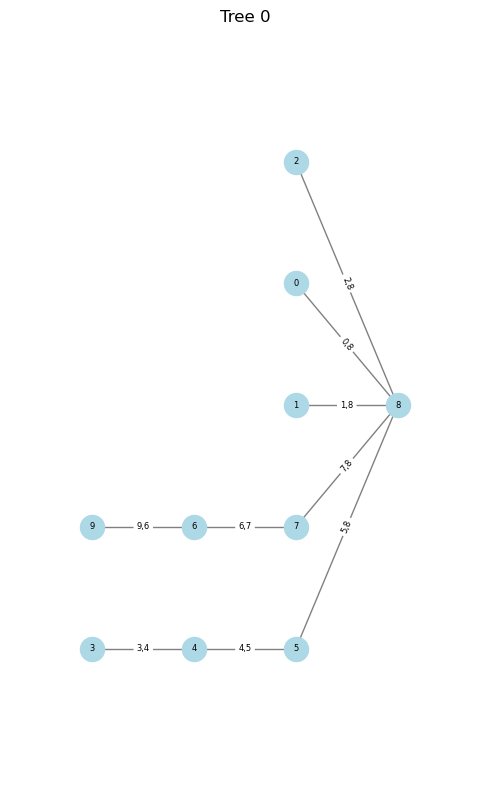

In [11]:
vine_model.plot(tree=[0])

In [12]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [13]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_84295/1520218578.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_84295/1520218578.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_84295/1520218578.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

In [14]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [15]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_84295/2452348847.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_84295/2452348847.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_84295/2452348847.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

In [16]:
#_ = plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [17]:
#_ = plot_marginals(simulated_data_train)

In [18]:
class Copula_2D_Dataset(Dataset):
    def __init__(self, data):
        
        # First Dimension (N) needs to be the samples
        # Second Dimension (D) is the dimensionality of the data
        self.data = data
    
    def __len__(self):
        return self.data.size(0)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
# Create dataset and DataLoader
dataset_train = Copula_2D_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Copula_2D_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

In [19]:
# Here you can see that we load the full data, so not batches
# Model is just implemented with dataloaders because that is eeded for huge datasets in bioinformatics
data_iter = iter(dataloader_train)
sample = next(data_iter)
sample.size()

torch.Size([2000, 10])

### 2. Define Model

In [20]:
model = GTM(
    transformation_spline_range=list([[-15], [15]]), 
    degree_decorrelation=40,
    degree_transformations=15,
    num_decorr_layers=3,
    num_trans_layers=1,
    number_variables=10,
    calc_method_bspline="deBoor",
    affine_decorr_layer=False,
    device="cpu") 

### 3. Hyperparameter Tune and Train Model

In [21]:
study = model.hyperparameter_tune_penalties( 
                                train_dataloader=dataloader_train, 
                                validate_dataloader=dataloader_validate, 
                                penvalueridge = [0], #["sample"],
                                penfirstridge = ["sample"],
                                pensecondridge = ["sample"],
                                ctm_pensecondridge = [0], #["sample"],
                                lambda_penalty_params = [0], #["sample"], #[0],
                                train_covariates=False, 
                                validate_covariates=False, 
                                adaptive_lasso_weights_matrix = False,
                                learning_rate=1, 
                                iterations=1000, 
                                patience=5, 
                                min_delta=1e-7, 
                                optimizer='LBFGS', 
                                lambda_penalty_mode="square", 
                                objective_type="negloglik", 
                                seperate_copula_training=False,
                                max_batches_per_iter=False,
                                tuning_mode="optuna",
                                cross_validation_folds=False,
                                random_state_KFold=42,
                                device=None,
                                pretrained_transformation_layer=False,
                                n_trials=20,
                                temp_folder=".", 
                                study_name=None)
    
penalty_params=torch.FloatTensor([
                            0, #study.best_params["penvalueridge"],
                            study.best_params["penfirstridge"],
                            study.best_params["pensecondridge"],
                            0 #study.best_params["ctm_pensecondridge"]
                              ])
adaptive_lasso_weights_matrix = False
lambda_penalty_params= False #study.best_params["lambda_penalty_params"] #False

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-21 15:40:50,257] A new study created in RDB with name: no-name-ff939b09-cd0f-4763-bf07-4d3a02d6f1f0


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 7.257230827695732   pensecondridge_opt: 18.988425261665334   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:404: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  t=knots.T,
 18%|█▊        | 184/1000 [00:47<03:28,  3.91it/s]
[I 2025-05-21 15:41:38,186] Trial 0 finished with value: -6.916006565093994 and parameters: {'penfirstridge': 7.257230827695732, 'pensecondridge': 18.988425261665334}. Best is trial 0 with value: -6.916006565093994.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 8.844731920596114   pensecondridge_opt: 13.509777367297914   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 21%|██▏       | 213/1000 [00:56<03:27,  3.79it/s]
[I 2025-05-21 15:42:34,513] Trial 1 finished with value: -6.861380577087402 and parameters: {'penfirstridge': 8.844731920596114, 'pensecondridge': 13.509777367297914}. Best is trial 1 with value: -6.861380577087402.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.04260109974997851   pensecondridge_opt: 14.308962398370383   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 11%|█         | 109/1000 [00:29<04:01,  3.68it/s]
[I 2025-05-21 15:43:04,287] Trial 2 finished with value: -7.281329154968262 and parameters: {'penfirstridge': 0.04260109974997851, 'pensecondridge': 14.308962398370383}. Best is trial 1 with value: -6.861380577087402.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.2529575358025462   pensecondridge_opt: 10.933548972535224   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  9%|▊         | 87/1000 [00:23<04:04,  3.73it/s]
[I 2025-05-21 15:43:27,810] Trial 3 finished with value: -7.406711101531982 and parameters: {'penfirstridge': 0.2529575358025462, 'pensecondridge': 10.933548972535224}. Best is trial 1 with value: -6.861380577087402.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 23.226947660359478   pensecondridge_opt: 0.6862765962442597   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 20%|██        | 200/1000 [00:53<03:32,  3.77it/s]
[I 2025-05-21 15:44:20,999] Trial 4 finished with value: -6.856955051422119 and parameters: {'penfirstridge': 23.226947660359478, 'pensecondridge': 0.6862765962442597}. Best is trial 4 with value: -6.856955051422119.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 18.74808327517621   pensecondridge_opt: 29.35168063705491   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 12%|█▏        | 124/1000 [00:32<03:46,  3.86it/s]
[I 2025-05-21 15:44:53,269] Trial 5 finished with value: -7.003628730773926 and parameters: {'penfirstridge': 18.74808327517621, 'pensecondridge': 29.35168063705491}. Best is trial 4 with value: -6.856955051422119.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 4.453071899541935   pensecondridge_opt: 4.34915035906042   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 22%|██▏       | 219/1000 [00:56<03:21,  3.88it/s]
[I 2025-05-21 15:45:49,859] Trial 6 finished with value: -7.072941303253174 and parameters: {'penfirstridge': 4.453071899541935, 'pensecondridge': 4.34915035906042}. Best is trial 4 with value: -6.856955051422119.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 29.1471160530973   pensecondridge_opt: 20.312213688355417   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 16%|█▌        | 161/1000 [00:42<03:41,  3.79it/s]
[I 2025-05-21 15:46:32,563] Trial 7 finished with value: -6.928414821624756 and parameters: {'penfirstridge': 29.1471160530973, 'pensecondridge': 20.312213688355417}. Best is trial 4 with value: -6.856955051422119.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 18.94050373737133   pensecondridge_opt: 8.396861802788   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 22%|██▏       | 223/1000 [00:58<03:22,  3.84it/s]
[I 2025-05-21 15:47:30,857] Trial 8 finished with value: -6.834580898284912 and parameters: {'penfirstridge': 18.94050373737133, 'pensecondridge': 8.396861802788}. Best is trial 8 with value: -6.834580898284912.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 5.575509592664974   pensecondridge_opt: 7.49908296970035   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 16%|█▋        | 165/1000 [00:43<03:37,  3.83it/s]
[I 2025-05-21 15:48:14,121] Trial 9 finished with value: -7.060526371002197 and parameters: {'penfirstridge': 5.575509592664974, 'pensecondridge': 7.49908296970035}. Best is trial 8 with value: -6.834580898284912.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 18.725178293251332   pensecondridge_opt: 13.348723434021151   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 10%|█         | 102/1000 [00:26<03:56,  3.80it/s]
[I 2025-05-21 15:48:41,141] Trial 10 finished with value: -7.136041641235352 and parameters: {'penfirstridge': 18.725178293251332, 'pensecondridge': 13.348723434021151}. Best is trial 8 with value: -6.834580898284912.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 23.764098669894135   pensecondridge_opt: 0.42077949923157093   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 17%|█▋        | 166/1000 [00:43<03:36,  3.85it/s]
[I 2025-05-21 15:49:24,468] Trial 11 finished with value: -6.989620208740234 and parameters: {'penfirstridge': 23.764098669894135, 'pensecondridge': 0.42077949923157093}. Best is trial 8 with value: -6.834580898284912.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 23.626559542512666   pensecondridge_opt: 8.55670756983607   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 11%|█         | 106/1000 [00:27<03:55,  3.79it/s]
[I 2025-05-21 15:49:52,635] Trial 12 finished with value: -7.108657360076904 and parameters: {'penfirstridge': 23.626559542512666, 'pensecondridge': 8.55670756983607}. Best is trial 8 with value: -6.834580898284912.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 16.494614228120156   pensecondridge_opt: 6.563050348747511   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 27%|██▋       | 266/1000 [01:09<03:10,  3.85it/s]
[I 2025-05-21 15:51:01,995] Trial 13 finished with value: -6.8133864402771 and parameters: {'penfirstridge': 16.494614228120156, 'pensecondridge': 6.563050348747511}. Best is trial 13 with value: -6.8133864402771.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 17.107880481858302   pensecondridge_opt: 6.846455858077931   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 24%|██▎       | 235/1000 [01:02<03:22,  3.77it/s]
[I 2025-05-21 15:52:04,450] Trial 14 finished with value: -6.787020683288574 and parameters: {'penfirstridge': 17.107880481858302, 'pensecondridge': 6.846455858077931}. Best is trial 14 with value: -6.787020683288574.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 12.334762972140965   pensecondridge_opt: 1.1300738018195071   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 11%|█         | 109/1000 [00:28<03:56,  3.77it/s]
[I 2025-05-21 15:52:33,573] Trial 15 finished with value: -7.2775444984436035 and parameters: {'penfirstridge': 12.334762972140965, 'pensecondridge': 1.1300738018195071}. Best is trial 14 with value: -6.787020683288574.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 17.001499326187094   pensecondridge_opt: 21.164587710221475   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 20%|█▉        | 195/1000 [00:50<03:28,  3.86it/s]
[I 2025-05-21 15:53:24,309] Trial 16 finished with value: -6.920670986175537 and parameters: {'penfirstridge': 17.001499326187094, 'pensecondridge': 21.164587710221475}. Best is trial 14 with value: -6.787020683288574.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 13.374251278561498   pensecondridge_opt: 9.322095544494328   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 22%|██▏       | 221/1000 [00:58<03:25,  3.79it/s]
[I 2025-05-21 15:54:22,774] Trial 17 finished with value: -6.8537139892578125 and parameters: {'penfirstridge': 13.374251278561498, 'pensecondridge': 9.322095544494328}. Best is trial 14 with value: -6.787020683288574.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 29.00952138099087   pensecondridge_opt: 6.390737692462563   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 19%|█▊        | 186/1000 [00:49<03:35,  3.77it/s]
[I 2025-05-21 15:55:12,236] Trial 18 finished with value: -6.8293561935424805 and parameters: {'penfirstridge': 29.00952138099087, 'pensecondridge': 6.390737692462563}. Best is trial 14 with value: -6.787020683288574.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 25.298498699752802   pensecondridge_opt: 14.608697139809959   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 13%|█▎        | 128/1000 [00:33<03:49,  3.81it/s]
[I 2025-05-21 15:55:46,047] Trial 19 finished with value: -7.090094089508057 and parameters: {'penfirstridge': 25.298498699752802, 'pensecondridge': 14.608697139809959}. Best is trial 14 with value: -6.787020683288574.


hyperparameter_tuning done


In [22]:
penalty_params

tensor([ 0.0000, 17.1079,  6.8465,  0.0000])

In [42]:
penalty_params=torch.FloatTensor([
                            0, #study.best_params["penvalueridge"],
                            1, #study.best_params["penfirstridge"],
                            5, #study.best_params["pensecondridge"],
                            0, #study.best_params["ctm_pensecondridge"]
                              ])
adaptive_lasso_weights_matrix = False
lambda_penalty_params=False

In [23]:
# pretrain the marginal transformations
_ = model.pretrain_tranformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_params=penalty_params)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_model/gtm.py:296: UserWarning: Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.
  warnings.warn("Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.")
  8%|▊         | 84/1000 [00:06<01:14, 12.32it/s]


In [24]:
# train the joint model
_ = model.__train__(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS", learning_rate=1,
                penalty_params=penalty_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, lambda_penalty_params=lambda_penalty_params, 
                max_batches_per_iter=False)

 18%|█▊        | 179/1000 [00:51<03:57,  3.46it/s]


### 4. Compare Fit to Benchmarks

In [25]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [26]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)  # 0 to do mean across dim 0 not globally
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [27]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.733
KLD Gaussian Train Data:  3.3577
KLD Copula   Train Data:  0.0093
KLD GTM      Test  Data:  1.1632
KLD Gaussian Test  Data:  3.4445
KLD Copula   Test  Data:  0.0322


KLD GTM      Train Data:  0.7392
KLD Gaussian Train Data:  3.2368
KLD Copula   Train Data:  0.0207
KLD GTM      Test  Data:  1.169
KLD Gaussian Test  Data:  3.3249
KLD Copula   Test  Data:  0.0394

In [28]:
# save model
torch.save(model, "10D_rvine_model_state_dict.pth")
#model = torch.load("./10D_rvine_model_state_dict.pth")

### 5. Evaluate and Plot GTM Results

In [29]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(2000)

In [30]:
#_ = plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])

In [31]:
synthetic_samples = model.sample(2000)
conditional_correlation_matrix_train = model.compute_correlation_matrix(synthetic_samples)

In [32]:
#_ = plot_metric_scatter(data=synthetic_samples,metric=conditional_correlation_matrix_train,metric_type="precision_matrix")

did it identify the cis?

In [58]:
conditional_independence_table2 = model.compute_conditional_independence_table(
                                        y = None,
                                        x = False,
                                        evaluation_data_type = "samples_from_model",
                                        num_processes=4,
                                        sample_size = 5000,
                                        num_points_quad=10,
                                        optimized=True,
                                        copula_only=True)

Processing row 0 with var_row_num 1 and var_col_num 0.
Processing row 3 with var_row_num 3 and var_col_num 0.
Processing row 6 with var_row_num 4 and var_col_num 0.
Processing row 9 with var_row_num 4 and var_col_num 3.


/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:404: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  t=knots.T,
/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:404: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/sr

Processing row 4 with var_row_num 3 and var_col_num 1.
Processing row 10 with var_row_num 5 and var_col_num 0.
Processing row 1 with var_row_num 2 and var_col_num 0.
Processing row 7 with var_row_num 4 and var_col_num 1.
Processing row 5 with var_row_num 3 and var_col_num 2.
Processing row 11 with var_row_num 5 and var_col_num 1.
Processing row 2 with var_row_num 2 and var_col_num 1.
Processing row 8 with var_row_num 4 and var_col_num 2.
Processing row 12 with var_row_num 5 and var_col_num 2.
Processing row 15 with var_row_num 6 and var_col_num 0.
Processing row 18 with var_row_num 6 and var_col_num 3.
Processing row 21 with var_row_num 7 and var_col_num 0.
Processing row 13 with var_row_num 5 and var_col_num 3.
Processing row 16 with var_row_num 6 and var_col_num 1.
Processing row 19 with var_row_num 6 and var_col_num 4.
Processing row 22 with var_row_num 7 and var_col_num 1.
Processing row 14 with var_row_num 5 and var_col_num 4.
Processing row 17 with var_row_num 6 and var_col_num 2

In [59]:
conditional_independence_table2

,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae
10,1,0,0.130672,0.030188,0.065359,0.006809,0.003458,0.048348
20,2,0,0.298501,0.136463,0.095325,0.013157,0.016557,0.097532
21,2,1,0.156284,0.038252,0.066311,0.007179,0.010960,0.070178
30,3,0,0.128217,0.024678,0.059504,0.005329,0.004229,0.051077
31,3,1,0.060777,0.005742,0.036282,0.002079,0.002563,0.042285
32,3,2,0.112575,0.021200,0.039262,0.002392,0.009081,0.058142
40,4,0,0.085129,0.010212,0.034702,0.001738,0.003806,0.043271
41,4,1,0.121463,0.021952,0.062389,0.005912,0.007381,0.065356
42,4,2,0.307460,0.112218,0.096491,0.011204,0.008307,0.069585
43,4,3,1.814102,3.350703,0.794375,0.633263,0.387458,0.449599


In [ ]:
conditional_independence_table = model.compute_conditional_independence_table(
                                        y = simulated_data_train, #None,
                                        x = False,
                                        evaluation_data_type = "data", #samples_from_model",
                                        num_processes=1,
                                        sample_size = 5000,
                                        num_points_quad=10,
                                        optimized=True,
                                        copula_only=True)

Processing row 0 with var_row_num 1 and var_col_num 0.
Processing row 1 with var_row_num 2 and var_col_num 0.
Processing row 2 with var_row_num 2 and var_col_num 1.
Processing row 3 with var_row_num 3 and var_col_num 0.
Processing row 4 with var_row_num 3 and var_col_num 1.
Processing row 5 with var_row_num 3 and var_col_num 2.
Processing row 6 with var_row_num 4 and var_col_num 0.
Processing row 7 with var_row_num 4 and var_col_num 1.
Processing row 8 with var_row_num 4 and var_col_num 2.
Processing row 9 with var_row_num 4 and var_col_num 3.
Processing row 10 with var_row_num 5 and var_col_num 0.
Processing row 11 with var_row_num 5 and var_col_num 1.
Processing row 12 with var_row_num 5 and var_col_num 2.
Processing row 13 with var_row_num 5 and var_col_num 3.
Processing row 14 with var_row_num 5 and var_col_num 4.
Processing row 15 with var_row_num 6 and var_col_num 0.
Processing row 16 with var_row_num 6 and var_col_num 1.
Processing row 17 with var_row_num 6 and var_col_num 2.
Pr

In [46]:
conditional_independence_table

,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae
10,1,0,0.130883,0.029357,0.065635,0.006726,0.004159,0.045704
20,2,0,0.289226,0.126183,0.093822,0.012843,0.004649,0.090118
21,2,1,0.154703,0.037360,0.065037,0.006779,0.008797,0.066089
30,3,0,0.121454,0.022630,0.056185,0.004868,0.006280,0.046658
31,3,1,0.059098,0.005539,0.035526,0.002047,0.002151,0.042299
32,3,2,0.109407,0.020070,0.038088,0.002253,0.007348,0.055389
40,4,0,0.083891,0.010055,0.034360,0.001742,0.002974,0.041348
41,4,1,0.121690,0.022152,0.063110,0.006121,0.006403,0.064561
42,4,2,0.300572,0.107579,0.094119,0.010641,0.004856,0.063105
43,4,3,1.803154,3.320621,0.792900,0.631256,0.374569,0.456228


In [31]:
from gtm.gtm_plots_analysis.compute_precision_matrix_summary_statistics import compute_precision_matrix_summary_statistics

In [32]:
synthetic_samples = model.sample(10000)
cond_corr_matrix = model.compute_correlation_matrix(synthetic_samples)
#cond_corr_matrix = model.compute_precision_matrix(simulated_data_train)
cond_corr_matrix_summary_statistics = compute_precision_matrix_summary_statistics(cond_corr_matrix)

In [33]:
conditional_independence_table = cond_corr_matrix_summary_statistics[["var_row",	"var_col",	"abs_mean"]]

In [47]:
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub["var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub["var_col"] = df_true_structure_sub["var_col"] - 1
df_true_structure_sub

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_84295/800703291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_structure_sub["var_row"] = df_true_structure_sub["var_row"] - 1
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_84295/800703291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_structure_sub["var_col"] = df_true_structure_sub["var_col"] - 1


,var_row,var_col,dependence
0,8,2,1
1,9,6,1
2,4,3,1
3,8,0,1
4,8,1,1
5,7,6,1
6,5,4,1
7,8,7,1
8,8,5,1
9,7,2,1


I had an index

In [60]:
merged = pd.merge(
    conditional_independence_table2,
    df_true_structure_sub,
    on=["var_row", "var_col"] # or "inner", "left", depending on your needs
)
merged.shape


(45, 9)

In [61]:
merged.sort_values("iae",ascending=False) #.sort_values("abs_mean",ascending=False) #.sort_values("iae",ascending=False)

,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae,dependence
9,4,3,1.814102,3.350703,0.794375,0.633263,0.387458,0.449599,1
28,8,0,2.733715,8.125902,0.694233,0.484976,0.274952,0.431728,1
42,9,6,1.749803,3.249647,0.663920,0.444391,0.224758,0.393844,1
14,5,4,2.226012,5.043569,0.579539,0.340130,0.231575,0.357167,1
30,8,2,2.454144,7.617582,0.450815,0.223649,0.171828,0.308868,1
35,8,7,2.493917,6.742613,0.441144,0.213793,0.158864,0.305461,1
34,8,6,1.703585,3.150872,0.375385,0.149876,0.153716,0.296173,1
27,7,6,2.046760,4.622615,0.474131,0.244841,0.150999,0.285882,1
26,7,5,2.378639,6.571157,0.416982,0.189040,0.159221,0.280657,1
43,9,7,1.350220,1.914697,0.410921,0.174237,0.120154,0.262809,1


In [62]:
merged.corr("spearman")

,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae,dependence
var_row,1.000000,0.468889,0.184826,0.189022,0.137937,0.144930,0.196948,0.183960,0.235504
var_col,0.468889,1.000000,0.307111,0.297321,0.171173,0.183228,0.333087,0.322364,0.335415
precision_abs_mean,0.184826,0.307111,1.000000,0.998419,0.952042,0.954677,0.930567,0.961397,0.772905
precision_square_mean,0.189022,0.297321,0.998419,1.000000,0.951779,0.955336,0.933992,0.964822,0.772905
cond_correlation_abs_mean,0.137937,0.171173,0.952042,0.951779,1.000000,0.999078,0.909223,0.941897,0.755259
cond_correlation_square_mean,0.144930,0.183228,0.954677,0.955336,0.999078,1.000000,0.915283,0.947167,0.758788
kld,0.196948,0.333087,0.930567,0.933992,0.909223,0.915283,1.000000,0.981291,0.762317
iae,0.183960,0.322364,0.961397,0.964822,0.941897,0.947167,0.981291,1.000000,0.783493
dependence,0.235504,0.335415,0.772905,0.772905,0.755259,0.758788,0.762317,0.783493,1.000000


In [63]:
merged.corr("pearson")

,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae,dependence
var_row,1.000000,0.500000,0.248475,0.239255,0.191632,0.141357,0.147071,0.219018,0.276395
var_col,0.500000,1.000000,0.317690,0.265355,0.241185,0.204713,0.293854,0.318321,0.345494
precision_abs_mean,0.248475,0.317690,1.000000,0.961674,0.918673,0.830883,0.880786,0.943771,0.827607
precision_square_mean,0.239255,0.265355,0.961674,1.000000,0.825247,0.766942,0.819368,0.857331,0.748524
cond_correlation_abs_mean,0.191632,0.241185,0.918673,0.825247,1.000000,0.963329,0.956603,0.982771,0.807402
cond_correlation_square_mean,0.141357,0.204713,0.830883,0.766942,0.963329,1.000000,0.973013,0.938532,0.730431
kld,0.147071,0.293854,0.880786,0.819368,0.956603,0.973013,1.000000,0.965960,0.770968
iae,0.219018,0.318321,0.943771,0.857331,0.982771,0.938532,0.965960,1.000000,0.825776
dependence,0.276395,0.345494,0.827607,0.748524,0.807402,0.730431,0.770968,0.825776,1.000000


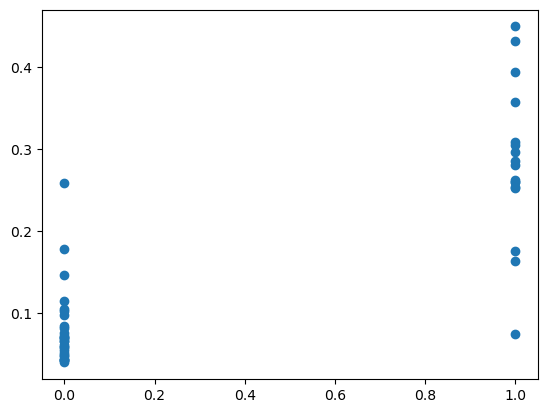

In [64]:
plt.scatter(merged["dependence"],merged["iae"])

In [ ]:
#_ = plot_splines(model.transformation,simulated_data_train)

In [ ]:
#_ = plot_splines(model.decorrelation_layers[0],simulated_data_train)

In [ ]:
#_ = plot_splines(model.decorrelation_layers[1],simulated_data_train)

In [ ]:
#_ = plot_splines(model.decorrelation_layers[2],simulated_data_train)